<a href="https://colab.research.google.com/github/Jed-77/tensorflow-deeplearning/blob/master/TF2_0_GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Install packages
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os

In [0]:
# Load the data
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0 * 2 - 1, x_test / 255.0 * 2 - 1  # range between -1 and 1 for better training
print("X_Train Shape: ", x_train.shape)

11493376/11490434 [==============================] - 0s 0us/step
X_Train Shape:  (60000, 28, 28)


In [0]:
# Flatten the data for the ANN
N, H, W = x_train.shape
D = H * W   # number of features is the height * width (so length of vector)
x_train = x_train.reshape(-1, D)
x_test = x_test.reshape(-1, D)

In [0]:
# Dimensionality of the latent space
latent_dim = 100

In [0]:
# Function to build the generator model
# Uses the latent dimension to build some input of size latent_dim * 1 (flattened) and gets passed through a ANN,
# ... and outputs a dense layer of size D * 1 (so equivalent to an MNIST flattened).
# Also note, we are output a 'regression' (range of values) so use tanh. Note this is 
# ... consistent with the code x_train = x_train / 255.0 * 2 - 1

def build_generator(latent_dim):
  i = Input(shape=(latent_dim,))
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(1024, activation=LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(D, activation='tanh')(x)
  model = Model(i, x)
  return model

In [0]:
# Function to build the discriminator model
# Take an flattened image and do a classificaiton on it, fake or real(hence sigmoid)

def build_discriminator(img_size):
  i = Input(shape=(img_size, ))
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
  x = Dense(1, activation='sigmoid')(x)
  model = Model(i, x)
  return model


In [0]:
# Compile both models in preparation for training

# Build and compile discriminator
discriminator = build_discriminator(D)   #takes an image of size D
discriminator.compile(
    loss='binary_crossentropy',  # binary as real/fake
    optimizer=Adam(0.0002, 0.5),
    metrics=['accuracy']
)

# Build and compile the combined model
generator = build_generator(latent_dim)
z = Input(shape=(latent_dim,))  # crete a an input which is noise sample from latent space
img = generator(z)  # generate an image from this noise, by passing it through the generator
discriminator.trainable = False   # for the combined model, the discriminator is not trainable
fake_pred = discriminator(img)    # pass the image through the current discriminator and see what it predicts
combined_model = Model(z, fake_pred)   # the combined model uses the input as noise sample from latent space, and output as the real/fake prediction (linked to previous steps so has NN in them)
combined_model.compile(loss='binary_crossentropy', # binary as real/fake
                       optimizer=Adam(0.0002, 0.5))

In [0]:
# Train the GAN

# Config
batch_size = 32
epochs = 4000
sample_period = 200  # save some data every sample_period steps 

# Create batch labels to use when calling train_on_batch
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

# Store the losses
d_losses = []
g_losses = []

# Create a folder to store generated images
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')


In [0]:
# Function to generate a grid of random samples from the generator and save them to a file
def sample_images(epoch):
  # Make 25 images on a 5x5 grid
  rows, cols = 5, 5
  noise = np.random.randn(rows*cols, latent_dim)
  imgs = generator.predict(noise)
  # Rescale between 0 -> 1
  imgs = 0.5 * imgs + 0.5 
  # Do the plotting
  fig, axs = plt.subplots(rows, cols)
  idx = 0
  for i in range(rows):
    for j in range(cols):
      axs[i, j].imshow(imgs[idx].reshape(H, W), cmap='gray')
      axs[i, j].axis('off')
      idx += 1
  fig.savefig("gan_images/{}.png".format(epoch))
  plt.close()


In [0]:
# Main Training Loop

for epoch in range(epochs):
  ###############################
  ## 1. Train Discriminator #####
  ###############################
  # 1.A. Select a random batch (batch_size) of real images from training set
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  real_imgs = x_train[idx]
  # 1.B. Generate some fake images using the generator
  noise = np.random.randn(batch_size, latent_dim)
  fake_imgs = generator.predict(noise)
  # 1.C Train the Discriminator to classify real (one) vs fake (zeros)
  d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
  d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
  d_loss = 0.5 * (d_loss_real + d_loss_fake)
  d_acc = 0.5 * (d_acc_real + d_acc_fake)

  ###############################
  ## 2. Train Generator  ########
  ###############################
  # 2.A Generator some fake images using the generator
  noise = np.random.randn(batch_size, latent_dim)
  # 2.B Feed noise through combined model (holding Discrimiator constant) and train on y_hat = ones (so it tries to pass fake image as real)
  g_loss = combined_model.train_on_batch(noise, ones)


  # Save the losses
  d_losses.append(d_loss)
  g_losses.append(g_loss)

  if epoch % 100 == 0:
    print("Epoch: {x}, D_Loss: {y}, G_Loss: {z}, D_Acc: {a}".format(x=epoch, y=d_loss, z=g_loss, a = d_acc))
  if epoch % sample_period == 0:
    sample_images(epoch)

Epoch: 0, D_Loss: 0.35807161778211594, G_Loss: 0.7091542482376099, D_Acc: 0.859375
Epoch: 100, D_Loss: 0.007565186475403607, G_Loss: 4.6077752113342285, D_Acc: 1.0
Epoch: 200, D_Loss: 0.11295014765306632, G_Loss: 5.14946985244751, D_Acc: 0.921875
Epoch: 300, D_Loss: 0.4693940579891205, G_Loss: 2.071531295776367, D_Acc: 0.796875
Epoch: 400, D_Loss: 0.6791573464870453, G_Loss: 1.048224687576294, D_Acc: 0.609375
Epoch: 500, D_Loss: 0.5880458056926727, G_Loss: 0.8758740425109863, D_Acc: 0.65625
Epoch: 600, D_Loss: 0.5968916416168213, G_Loss: 0.9349055886268616, D_Acc: 0.734375
Epoch: 700, D_Loss: 0.5892913341522217, G_Loss: 0.937584400177002, D_Acc: 0.6875
Epoch: 800, D_Loss: 0.5928500592708588, G_Loss: 0.8759942054748535, D_Acc: 0.71875
Epoch: 900, D_Loss: 0.5508514642715454, G_Loss: 0.8758578896522522, D_Acc: 0.765625
Epoch: 1000, D_Loss: 0.559818223118782, G_Loss: 0.9526654481887817, D_Acc: 0.703125
Epoch: 1100, D_Loss: 0.5110131949186325, G_Loss: 1.0160768032073975, D_Acc: 0.8125
Epoch

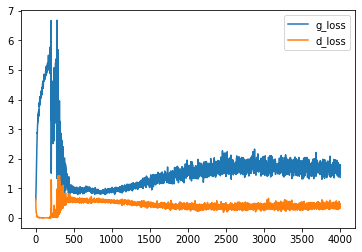

In [0]:
# plot the losses 
plt.plot(g_losses, label='g_loss')
plt.plot(d_losses, label='d_loss')
plt.legend()

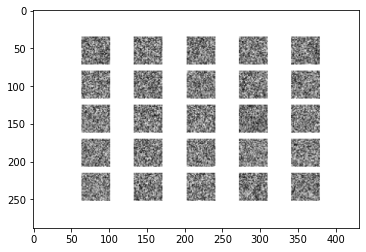

In [0]:
# First Epoch - JUST NOISE!!
from skimage.io import imread
a = imread('gan_images/0.png')
plt.imshow(a)

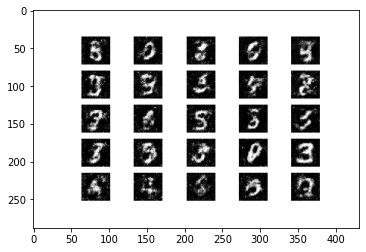

In [0]:
# 3000 Epochs
from skimage.io import imread
a = imread('gan_images/3000.png')
plt.imshow(a)